![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **Text Analysis of Beer Reviews**
Here we use pySpark to analyze the text in the commercial description and review text to create similarity scores between beers.  The scores can then be used for clustering and beer style identification or to find beers similar to what a user enjoys, as a recommendation service.

### **Preliminaries**
#### We read in the allBeer.txt file and create an RDD consisting of lines.
#### We want to remove the header from the file, so the parseDataFileLine function identifies lines starting with 'beer_id' and applies a flag of 0, other lines with the correct number of fields are flagged 1, and incorrect lines are flagged -1.  The lines are split into arrays.

In [7]:
import re

def parseDatafileLine(datafileLine):
    ##Parse a line of the data file using the specified regular expression pattern
    splitArray = datafileLine.split("\t")
    for x in range(0,len(splitArray)):
        splitArray[x]=splitArray[x].replace("\"",'')
    #print len(splitArray)
    #print splitArray[0],splitArray[1],splitArray[2]
    if splitArray[0]=='beer_id':
        return (splitArray,0)
    elif len(splitArray)<>23:
        ##this is a failed parse
        return (splitArray,-1)
    else:
        return (splitArray, 1)

### Reading the file
#### We read the file into three rdds by first parsing the file as above, the header rdd, failed rdd and the valid rdd.  Print the header names so we can remember what fields we're dealing with and in what order.

In [8]:
import sys
import os

baseDir = os.path.join('')
allBeer_Path = 'AllBeer.txt'
STOPWORDS_PATH = 'stopwords.txt'

def parseData(filename):
    #Parse a data file returns a RDD of parsed lines
    
    return (sc
            .textFile(filename, 4, 0)
            .map(parseDatafileLine)
            .cache())

def loadData(path):
    ##Load a data file, returns a RDD of parsed valid lines
    
    filename = os.path.join(baseDir, path)
    raw = parseData(filename).cache()
    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    for line in failed.take(10):
        print '%s - Invalid datafile line: %s' % (path, line)
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    header = (raw
              .filter(lambda s: s[1]==0)
             .map(lambda s:s[0])
             )
    for line in header.take(1):
        for x in range(0,len(line)):
            print x,line[x]
            
    rawLines = raw.count()
    validLines = valid.count()
    failedLines = failed.count()
    print '%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path, rawLines, validLines,failedLines)
    return valid
    
allBeer = loadData(allBeer_Path)
#allReviews = loadData(allReviews_Path)

0 beer_id
1 beer_name
2 brewer_name
3 beer_style
4 distribution
5 brewery_location
6 commercial_desc
7 RATINGS: 
8 MEAN (/5)
9 WEIGHTED AVG
10 EST. CALORIES
11 ABV (%)
12 IBU
13 SCORE
14 AROMA (/10)
15 APPEARANCE(/5)
16 TASTE(/10)
17 PALATE(/5)
18 OVERALL(/20)
19 reviewer_name
20 review_location
21 review_date
22 review_content
AllBeer.txt - Read 240355 lines, successfully parsed 240354 lines, failed to parse 0 lines


### Let's examine the first few entries of a sample of 5 lines to check if things look ok.

In [9]:
sampleArray=allBeer.takeSample(False,5,1)
for line in sampleArray:
    print len(line)
    print 'allBeer: %s, %s, %s, %s, %s\n' % (line[0], line[1], line[2],line[3],line[4])

23
allBeer: 40920, Wernecker Haustrunk Pils, Wernecker Bierbrauerei, Pilsener, distribution unknown

23
allBeer: 21911, Au Ma'tre Brasseur La Boucaneuse, AMB - Ma'tre Brasseur, Smoked, distribution unknown

23
allBeer: 4991, New Albanian / Struise Naughty Girl, New Albanian Brewing Company, India Pale Ale (IPA), Regional Distribution

23
allBeer: 38430, BrewDog IPA is Dead - Pioneer, BrewDog, India Pale Ale (IPA), Broad Distribution

23
allBeer: 41353, Cascade Cerise Nouveau, Cascade Brewing, Sour/Wild Ale, Local Distribution



### Now we'll split the data into a training set (80%) and test set (%20).  
#### This is slightly complicated by the fact that we want to split each user into 80/20, not the set of reviews as a whole.  We will take advantage of stratified sampling in Spark, grouping the reviews by the user name, then sampling by key.  To get the unused data we employ subtractByKey using a compound key of the username and the beer_id, guaranting uniqueness.

In [10]:
##Using the allBeer array, take stratified sample, and remove blank reviews.
beerByUser = allBeer.map(lambda x:(x[19],x)).filter(lambda (x,y):y[22]!='')
sampleKeys = beerByUser.keys().collect()
fractions={}
for k in sampleKeys:
    fractions[k]=0.8
    
beerTrain = beerByUser.sampleByKey(False,fractions).cache()
beerTrainKeyed = beerTrain.map(lambda (x,y):(y[0]+y[19],y))
beerTest = allBeer.map(lambda x:(x[0]+x[19],x)).subtractByKey(beerTrainKeyed).map(lambda (x,y):(y[19],y)).cache()
print beerByUser.count()
print beerTrain.count()
print beerTest.count()

240334
192427
47927


### Let's examine the results with a couple of random users.

In [46]:
from numpy.random import random_integers
##find a random user and print out the train and test set.
randomUsers = random_integers(1,len(sampleKeys),2)
sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[0]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[0]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

sampleUserReviewCount = beerByUser.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTrainCount = beerTrain.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
sampleUserTestCount = beerTest.filter(lambda (x,y):x==sampleKeys[randomUsers[1]]).count()
print "The user %s has %d reviews, split into %d Train and %d Test" % (sampleKeys[randomUsers[1]],sampleUserReviewCount,sampleUserTrainCount,sampleUserTestCount)

The user patrick767 has 259 reviews, split into 219 Train and 40 Test
The user LoveABeer has 5 reviews, split into 3 Train and 2 Test


### Scale the reviews:
#### Each user has a different way of scoring beers, some people judge more harshly than others.  In order to even out these scores, we get get statistics for each user and adjust their scores to fit a common distribution.  In this particular case we use a normal distribution for it's simplicity to execute.  Users with 1 or less reviews will have a standard deviation of 0, in which case we substitute 1 to ensure the division when obtaining z-scores we will not divide by zero.

In [12]:
from math import sqrt
##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def replaceZeroes(inputValue,replacementValue):
    if inputValue == 0:
        inputValue = replacementValue
    return inputValue

def subtractFromColumn(inputList,columnToChange,subtractAmount):
    inputList[columnToChange]=float(inputList[columnToChange])-subtractAmount
    return inputList

def divideColumn(inputList,columnToChange,divisor):
    inputList[columnToChange]=float(inputList[columnToChange])/divisor
    return inputList


### rewrite this to be RDD of (key,everything else) and return (key, everything with normalized column x)
### Then run a few times and cache, and move this up into the preliminaries (post split)
def normalizeScoreByKey(inputRDD,scoreColumn):
    ##Takes in RDD of (key,array) and 
    ##returns RDD of (key,array with scoreColumn normalized)
    sumScores = inputRDD.map(lambda (x,y):(x,float(y[scoreColumn]))).reduceByKey(lambda a,b:a+b)
    #print sumScores.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    countScoresPerKey = inputRDD.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    #print countKeys.map(lambda (x,y):y).reduce(lambda a,b:a+b)
    averageScores = sumScores.join(countScoresPerKey).map(lambda (x,y):(x,y[0]/y[1]))
    #print averageScores.takeSample(False,5,3)
    centredScores = inputRDD.join(averageScores).map(lambda (x,(y,z)):(x,subtractFromColumn(y,scoreColumn,z)))
    #print centredScores.map(lambda (x,y):y[scoreColumn]).reduce(lambda a,b:a+b)
    centredScoresSquaredSum = centredScores.map(lambda (x,y):(x,y[scoreColumn]*y[scoreColumn])).reduceByKey(lambda a,b:a+b)
    centredScoresSquaredSumAndCount = centredScoresSquaredSum.join(countScoresPerKey)
    stdDeviationByKey = centredScoresSquaredSumAndCount.map(lambda (x,y):(x,sqrt(y[0]/y[1])))
    ##This is actually pointless since a centred score is 0 and 0/anything = 0
    ##countLines = stdDeviationByUser.count()
    ##avgStdDev = stdDeviationByUser.map(lambda (x,y):y).reduce(lambda a,b:a+b)/countLines
    stdDeviationByKeyNoZero = stdDeviationByKey.map(lambda (x,y):(x,replaceZeroes(y,1)))
    normalizedRDD = centredScores.join(stdDeviationByKeyNoZero).map(lambda (x,(y,z)):(x,divideColumn(y,scoreColumn,z)))
    return normalizedRDD

##Normalize the Scores
normalizedScores = normalizeScoreByKey(beerTrain,13)
##Normalize the rest of the ratings
#beerTrainNormA = normalizeScoreByKey(normalizedScores,14)
#beerTrainNormB = normalizeScoreByKey(beerTrainNormA,15)
#beerTrainNormC = normalizeScoreByKey(beerTrainNormB,16)
#beerTrainNormD = normalizeScoreByKey(beerTrainNormC,17)
beerTrainNormalized = normalizeScoreByKey(normalizedScores,18).cache()

print beerTrainNormalized.takeSample(False,5,4)


[('Skyview', ['18373', 'Rail House Brewers Best Pilsener', 'Rail House Restaurant and Brewery', 'Pilsener', 'Local Distribution', 'Marinette , Wisconsin USA', 'This classic Menominee-Marinette Brewery lager is brewed with only water, barley, hops, and is fermented at cave-like temperatures with lager yeast to produce its smooth character', '7.000', '2.910', '2.840', '150.000', '5.000', '', 0.18517035918953417, '6.000', '4.000', '6.000', '3.000', 0.7043100167332103, 'Skyview', 'Papoose Jct, Minnesota, USA ', 'JUL 2, 2007 ', "Another one of Menominee-Marinette brewery brands of the past revived by Rail House. On tap and in bottles at the brewpub, this beer pours a light golden amber brew with a thick white head that leaves an excellent lacing. Aroma is lighter than Silver Cream but still has light roasted malt, flowery hops and a touch of vanilla. Taste is lightly carbonated with a sweet doughy taste. Finish is semi-sweet and creamy with a good bitter balance. Though this is not the orig

### **Normalized Histograms**
#### Plot histograms of the normalized ratings to check to see if normality approximately holds.
#### Clearly score and overall are not normal, skewed right.  This would imply that when people hate a beer, they're more willing to review it harshly than they are willing to give a glowing review to a beer they love.

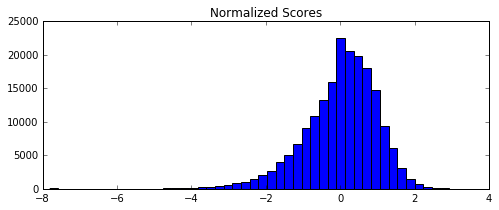

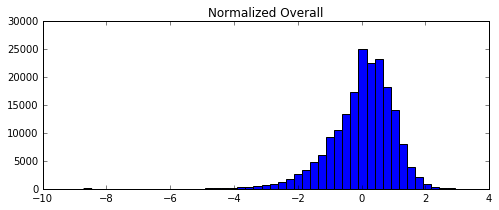

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
##Get all the normalized scores into one list.
scoreValues = beerTrainNormalized.map(lambda (x,y): y[13]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Scores')
plt.hist(scoreValues, 50, log=False)
overallValues = beerTrainNormalized.map(lambda (x,y): y[18]).collect()
fig = plt.figure(figsize=(8,3))
plt.title('Normalized Overall')
plt.hist(overallValues, 50, log=False)
pass

### Let's think about the test data set as if it were a menu in a pub
#### For each of the beers on the menu we need to generate a score, to see how compatable the beer is with the beer drinker's tastes.  From these scores we can then order the list, best to worst and the user can make their choice.  To do that we first need to know what the user likes, so let's take a look at their reviews and generate a list of traits, with each trait weighted by their own review scores.

### Step 1: Making Bags of Words
#### We can take the commercial descriptions and the user input text reviews and convert them into bags of words, we can then treat each word as a feature.  
#### We should take out stopwords before we do this, to avoid unfairly weighting reviews based on words which don't contribute much meaning, such as "the", "a", "is", "which", etc.

In [14]:
stopfile = os.path.join(baseDir, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())
testString = "This is a test of the tf function.  It should return non stopword frequencies frequency sourness"
print 'These are the stopwords: %s' % stopwords
split_regex = r'\W+'

#from nltk.stem.porter import PorterStemmer
#Stmmr = PorterStemmer()

def tokenize(string):
    ##takes in a string and tokenizes it, removing stopwords, returns list
    simple=filter(None,re.split(split_regex,string.lower()))
    #simple = [Stmmr.stem(i) for i in simple]
    return [i for i in simple if i not in stopwords]

print tokenize(testString)

These are the stopwords: set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'with', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'these', u't', u'each', u'where', u'because', u'doing', u'theirs', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'below', u'does', u'above', u'between', u'she', u'be', u'we', u'after', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'whom', u'there', u'been', u'few', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'off', u'herself', u'than', u'those', u'he', u'me', u'myself', u'this', u'up', u'will', u'while', u'can', u'were', u'my', u'and', u'then', u'is', u'in', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'further', u'their', u'if', u'again', u'no', u

### **Tokenizing the Commercial Description and Review**
#### Now tokenize the commercial descriptions and reviews. 
#### To see how much data we're dealing with let's count the total number of tokens.

In [15]:
##6 commercial description
##22 user input review
##make an RDD where the user_id is the key, and the value is 2 arrays of tokens 
##and the original line
beerTrainToToken = beerTrainNormalized.map(lambda (x,y):(y[19],(tokenize(y[6]),tokenize(y[22]),y)))

def countTokens(textRDD,reviewTRUE):
    ## Count and return the number of tokens
    if reviewTRUE==True:
        return textRDD.map(lambda (x,y):len(y[1])).reduce(lambda a,b:a+b)
    else:
        return textRDD.map(lambda (x,y):len(y[0])).reduce(lambda a,b:a+b)

print 'There are %s tokens in the commercial descriptions' % countTokens(beerTrainToToken,False)
print 'There are %s tokens in the reviews' % countTokens(beerTrainToToken,True)

There are 4664703 tokens in the commercial descriptions
There are 6679744 tokens in the reviews


### Let's get an idea of how big a review is

In [16]:
def findBiggestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):-len(y[0]))

def findSmallestRecord(textRDD,reviewTRUE):
    # Find and return the record with the largest number of tokens
    if reviewTRUE==True:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[1]))
    else:
        return textRDD.takeOrdered(1,lambda (x,y):len(y[0]))

biggestReview = findBiggestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the most tokens (%s)' % (biggestReview[0][0],
                                                                   len(biggestReview[0][1][1]))
smallestReview = findSmallestRecord(beerTrainToToken,True)
print 'The review from user "%s" has the least tokens (%s)' % (smallestReview[0][0], len(smallestReview[0][1][1]))

The review from user "SlovakSniper" has the most tokens (579)
The review from user "Shurf" has the least tokens (0)


### So clearly we've got some reviews that are empty, and we'll need some special handling for those.

### **Step 2: Weighted Bag-of-Words using TF-IDF**

### Term Frequency (TF) 
#### This gives higher weight to tokens that appear many times in a individual document. It is computed as the frequency of a token in a document. If a word occurs often in a document, then it is more important to the meaning of the document.

In [17]:
testString = "This is a test of the tf function.  It should return non stopword frequencies"
def tf(tokens):
    ###Compute TF from list of tokens, return dictionary of word:tf
    count = len(tokens)
    words={}
    for token in tokens:
        words[token]=float(len([t for t in tokens if t==token]))/count
    return words

print tf(tokenize(testString))

{'function': 0.14285714285714285, 'non': 0.14285714285714285, 'return': 0.14285714285714285, 'frequencies': 0.14285714285714285, 'stopword': 0.14285714285714285, 'tf': 0.14285714285714285, 'test': 0.14285714285714285}


### Inverse Document Frequency
#### This gives higher weight to tokens that are rare over the entire dataset. The rationale is two documents are more alike if they have in common words which are not common to rest data set.  IDF weight for a token in a set of documents is calculated as D/d(t) where D is the total number of documents and d(t) is the number of documents with term t.  
#### Keep in mind that the dataset for IDF is not the whole dataset, but the set of reviews for a particular user.  We want to find out what is special to that individual.

In [18]:
def countEachToken(listOfTokens):
    ##Count the number of times each token appears in the list
    tokenSet = list(set(listOfTokens))
    tokenDict={}
    for token in tokenSet:
        tokenDict[token]=0
    for token in listOfTokens:
        tokenDict[token]=tokenDict[token]+1
    return tokenDict

def divideIntByDict(inputDict,inputInt):
    for entry in inputDict:
        inputDict[entry]=float(inputInt)/float(inputDict[entry])
    return inputDict


def IDFByKey(keyCorpus):
    uniqueTokens = keyCorpus.map(lambda (x,y):(x,list(set(y))))
    tokensByKey = uniqueTokens.reduceByKey(lambda a,b:a+b)
    tokensCountByKey = tokensByKey.map(lambda (x,y):(x,countEachToken(y)))
    countDocsByKey=keyCorpus.map(lambda (x,y):(x,1)).reduceByKey(lambda a,b:a+b)
    countDocsAndTokensByKey = tokensCountByKey.join(countDocsByKey)
    IDF=countDocsAndTokensByKey.map(lambda (x,y):(x,divideIntByDict(y[0],y[1])))
    return IDF

#RDD of (beer_id,text)
reviewTokens = beerTrainToToken.map(lambda (x,y):(x,y[1]))
reviewIDF=IDFByKey(reviewTokens)
print reviewIDF.takeSample(False,2,1)

[('toddomundo', {'rating': 1.0, 'ipa': 1.0, 'outstanding': 1.0, '60': 1.0, 'mild': 1.0, 'want': 1.0, 'exclusion': 1.0, 'would': 1.0, 'hops': 1.0, 'delightfully': 1.0, 'perfectly': 1.0, 'sure': 1.0, 'bold': 1.0, 'citrus': 1.0, '70': 1.0, 'put': 1.0, 'overwhelming': 1.0, 'compliments': 1.0, 'smooth': 1.0, 'bitterness': 1.0, 'citra': 1.0, 'claims': 1.0, 'ibu': 1.0}), ('Reid', {'growlette': 23.0, 'powdery': 23.0, 'ale': 5.75, 'alc': 7.666666666666667, 'yellow': 11.5, 'zing': 23.0, 'woods': 23.0, 'gc': 23.0, 'bomber': 4.6, 'mellow': 11.5, 'suicide': 23.0, 'absolutly': 23.0, '1930s': 23.0, 'helps': 23.0, 'pleasing': 11.5, 'brown': 7.666666666666667, 'yeast': 11.5, 'coloured': 11.5, 'putting': 23.0, 'surprise': 23.0, 'unrefridgerated': 23.0, 'impressive': 23.0, 'cloudy': 11.5, 'try': 23.0, 'small': 7.666666666666667, 'says': 11.5, 'sign': 23.0, 'past': 23.0, 'dried': 23.0, 'even': 23.0, 'business': 23.0, 'rum': 23.0, 'espresso': 23.0, 'hazy': 2.875, 'flowing': 23.0, 'ever': 23.0, 'movement': 

### **Implement a TF-IDF function**
#### We want to weight the individual features (words) by the user's given scores.  This should increase the weightings of words used only in positive reviews and greatly increase rare words in positive reviews.  We then create an RDD of (key, dictionary) where the dictionary is a ranked collection of each user's individual preferences.  We have a customized set of features which indicate what a user likes.

In [19]:
def multiplyDict(inputDict,multiplier):
    #multiplies every entry in a dictionary by a number.
    for item in inputDict:
        inputDict[item]=inputDict[item]*multiplier
    return inputDict

def stf(tokens, score):
    ### Compute S-TF
    tfsDict = tf(tokens)
    stfsDict = multiplyDict(tfsDict,score)
    return stfsDict

def multiplyTwoDicts(firstDict,secondDict):
    multDict = {token:firstDict[token]*secondDict[token] for token in firstDict}
    return multDict

def addTwoDicts(firstDict,secondDict):
    for token in firstDict:
        if token in secondDict:
            firstDict[token]=firstDict[token]+secondDict[token]
    for token in secondDict:
        if token in firstDict:
            pass
        else:
            firstDict[token]=secondDict[token]            
    return firstDict

##13 SCORE
##14 AROMA (/10)
##15 APPEARANCE(/5)
##16 TASTE(/10)
##17 PALATE(/5)
##18 OVERALL(/20)

def stfidfByKey(inputRDD,idfRDD,reviewTrue,whichRating):
    ##Takes RDD of form (key,(list,list,wholebeer)) and calculates the s-tf of 
    ##reviewTrue==True ===> review
    ##reviewTrue==False ===> commercial Description
    ##whichRating ==-1 => don't weight by any column, just use 1 as a factor
    ##takes the sum of s-tf and applies the idf to it.
    
    if (whichRating < 13 or whichRating >18) and whichRating!=-1:
        raise ValueError('whichRating must be between 13 and 18 or equal to 0, please refer to documentation about fields')
                         
    if reviewTrue==True:
        #print "Got past true"
        #print inputRDD.map(lambda (x,(a,b,c)):(x,(b,c[whichRating]))).takeSample(False,3,1)
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,float(c[whichRating]))))).reduceByKey(addTwoDicts)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(b,1)))).reduceByKey(addTwoDicts)
        #print stfRDD.takeSample(True,3,1)
    else:
        if whichRating!=-1:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,float(c[whichRating]))))).reduceByKey(lambda a,b:a+b)
        else:
            stfRDD = inputRDD.map(lambda (x,(a,b,c)):(x,(stf(a,1)))).reduceByKey(lambda a,b:a+b)
            
    stfidfRDD=stfRDD.join(idfRDD).map(lambda (x,(y,z)):(x,multiplyTwoDicts(y,z)))
    #print stfidfRDD.takeSample(True,3,1)
    return stfidfRDD

    
#Generate dictionaries of ranked terms for each user individually.
scoreTfIdf = stfidfByKey(beerTrainToToken,reviewIDF,True,13)
##Find the best keywords across all users.
sumAllFeatures =scoreTfIdf.map(lambda (x,y):y).reduce(addTwoDicts)
#print sumAllFeatures.takeSample(False,3,1)

import operator
sorted_features = sorted(sumAllFeatures.items(), key=operator.itemgetter(1))
print "There are %d unique features in the reviews" % len(sorted_features)
print "The beer features which people hate the most are: "
print sorted_features[:20]
print "The beer features which people love the most are: "
print sorted_features[-20:]


There are 98783 unique features in the reviews
The beer features which people hate the most are: 
[('corn', -7014.251825890144), ('watery', -5925.509322959493), ('water', -4928.041378560695), ('lager', -4740.113953848786), ('bad', -4306.574231581611), ('metallic', -4148.324447660767), ('bland', -3913.7738413193733), ('cardboard', -3803.313819379331), ('nothing', -3633.9394346164154), ('boring', -3336.7367919585945), ('infected', -3115.6792169872647), ('artificial', -3112.3214606628317), ('grainy', -3032.0488878679444), ('stale', -3029.2839249377503), ('much', -2891.328086952873), ('pale', -2879.0751470069335), ('unpleasant', -2741.4630590838538), ('weak', -2695.0830170819663), ('thin', -2609.3817147933737), ('flat', -2551.3215369115374)]
The beer features which people love the most are: 
[('dark', 1902.5681941086914), ('complex', 2002.4319337771572), ('awesome', 2032.0293577971988), ('great', 2054.2344876100583), ('grapefruit', 2128.388046714417), ('full', 2197.5481243727963), ('balanc

# Fantastic!
### By amalgamating people's individual love/hates we show here that our intuition lines up with the methodology taken so far.  A vanilla bourbon beer beats an infected watery beer.

### Step 3:  Using reviews to identify features of each beer
#### Now that we have a user's preference, we need to figure out what each beer actually contains.  We can do this in a very similar way to the user features.  Collecting the reviews per beer, and applying tf-idf to the review text.  We will build a crowd sourced dictionary of terms that people commonly use to describe each beer.

### Generate the IDFs per beer:

In [20]:
### recall beerTrainNormalized is a normalized beerTrain which is 80% of each user's reviews.
### This takes the form of beerByUser = allBeer.map(lambda x:(x[19],x)) Where x is the entire
### line and x[19] is the user_id.  Let's remap this to use the beer id as the key
### similar to beerTrainToToken.

trainByBeer = beerTrainNormalized.map(lambda (x,y):(y[0],(tokenize(y[6]),tokenize(y[22]),y)))

### Remap to form similar to reviewTokens = beerTrainToToken.map(lambda (x,y):(x,y[1]))
### which is the input for the idfByKey function.
reviewTokensByBeer = trainByBeer.map(lambda (x,(a,b,c)):(x,b))

### Now apply the idfByKey Function to get the idf dictionaries for each beer
idfByBeer = IDFByKey(reviewTokensByBeer)
print idfByBeer.takeSample(False,2,1)

[('40872', {'gold': 7.0, 'cheap': 7.0, 'yellow': 7.0, 'aroma': 2.3333333333333335, 'mild': 3.5, 'touch': 3.5, 'still': 3.5, 'hops': 7.0, '3': 7.0, 'hay': 3.5, 'scarlett': 7.0, 'town': 7.0, 'good': 7.0, 'coloured': 7.0, 'prunes': 7.0, 'flavour': 3.5, 'day': 7.0, 'notes': 7.0, 'leave': 7.0, 'bad': 7.0, 'stuff': 7.0, 'celbridge': 7.0, 'lager': 7.0, 'house': 7.0, 'college': 7.0, 'pale': 3.5, 'lemongrass': 7.0, 'sun': 7.0, 'away': 7.0, 'overly': 7.0, 'enough': 7.0, 'shared': 7.0, 'neither': 7.0, 'bought': 7.0, 'body': 3.5, 'foam': 7.0, 'power': 7.0, 'pours': 7.0, 'corn': 3.5, 'pilsener': 7.0, 'dry': 3.5, 'schaffer': 7.0, 'package': 7.0, 'could': 3.5, 'days': 7.0, 'grain': 7.0, 'ehad': 7.0, 'golden': 2.3333333333333335, 'sweet': 7.0, 'clear': 3.5, 'duck': 7.0, 'hoppy': 7.0, 'decent': 7.0, 'anyone': 7.0, 'almost': 7.0, 'beer': 3.5, 'low': 7.0, 'ireland': 3.5, 'lacing': 7.0, 'mucky': 7.0, 'head': 3.5, 'drinkable': 3.5, 'mostly': 7.0, 'happily': 7.0, 'semisweet': 7.0, 'foamy': 7.0, 'linh': 7.0,

### Generate tf-idf of features in each beer.
#### Time to make a tf-idf for each beer, this time we won't weight it by the review, as we're trying to extract honest features from the beer, not each user's opinion about those features.  If someone indicates that the beer tastes like grapefruit but does not enjoy grapefruit, it doesn't mean that another user who does enjoy grapefruit will not.

In [21]:
beerTfIdf = stfidfByKey(trainByBeer,idfByBeer,True,-1)
print beerTfIdf.takeSample(False,2,1)

[('1535', {'houston': 0.21212121212121213, 'gold': 0.17748917748917747, 'summer': 0.7241379310344828, 'ale': 0.14, 'recipe': 0.14, 'aroma': 0.20028794233104577, 'enjoyable': 0.1808035714285714, 'mild': 0.20065520065520065, 'via': 0.2039695945945946, 'citrusy': 0.14, 'carbonation': 0.21875, 'flavor': 0.19068965517241382, 'buddy': 0.2039695945945946, '22': 0.14285714285714285, 'hops': 0.164992784992785, 'texture': 0.14285714285714285, 'actually': 0.14, 'hay': 0.21212121212121213, 'grapefruit': 0.36653006356670154, 'pretty': 0.2501501501501502, 'orange': 0.14613756613756615, '2014': 0.15555555555555556, 'whack': 0.21212121212121213, 'merchant': 0.21212121212121213, 'brown': 0.21212121212121213, 'good': 0.22675026123301986, 'citrus': 0.18715277777777778, 'big': 0.1921182266009852, 'overall': 0.21875, 'truly': 0.14285714285714285, 'bandage': 0.14, 'signiture': 0.3111111111111111, 'colour': 0.1891891891891892, 'crisp': 0.21875, 'like': 0.14, 'notes': 0.16158158158158162, 'dig': 0.14, 'bright

### Step 4:  Cosine distance

#### We now have two sets of features, one per user and one per beer.  How do we compare the two?  One method is to imagine a multidimensional space where each word, or feature is a direction.  The weight on each feature is the distance along that axis.  In order to compare, we measure the angle between the two vectors.  A smaller angle will correspond to vectors pointing in nearly the same direction.

#### The formula for cosine distance is:
#### $$ similarity = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} $$


### Implement the components of a cosine distance function
#### We need to make a function `similarity` that returns cosine distance given two dictionaries.  The dot product of two dictionaries divided by the magnitudes of each dictionary.  Since perpendicular components have a dot product of zero we can ignore features which do not appear in both dictionaries.  To do this we can use the intersection of their keys.

In [37]:
def similarity(a, b):
    if len(a)==0 or len(b)==0:
         sim=0
    else:
        aDotB= sum([a[token]*b[token] for token in list(set(a.keys())&set(b.keys()))])
        magA = sqrt(sum(a[token]*a[token] for token in a.keys()))
        magB = sqrt(sum(b[token]*b[token] for token in b.keys()))
        if magA!=0 and magB!=0:
            sim = aDotB/(magA*magB)
        else:
            sim=0
    return sim

testVec1 = {'foo': 2, 'bar': 2, 'baz': 2 }
testVec2 = {'foo': 3, 'bar': 2, 'baz': 1 }
print similarity(testVec1, testVec2)

testVec3 = {'foo': 20, 'bar': 1, 'baz': 1 }
print similarity(testVec1, testVec3)

testVec4={}
print similarity(testVec1, testVec4)

testVec5 = {'foo': 0, 'bar': 0, 'baz': 0 }
print similarity(testVec1, testVec5)

0.925820099773
0.633503512093
0


### Comparing a menu's worth of beers to a user
#### Recall that we split the original data set into 80% for training and 20% for test.  We consider the 20% of each user's reviews as a menu.  We can then compare each of the beers on the menu, using the features extracted from the training set to the features we extracted for each user.  By using the cosine similarity we can generate a score for each beer and rank them.  We can then compare this ranking to the user's given ratings.

In [49]:
### beerTest is of the form (user,line)
### we can remap this to (beer, line) and then join with beerTfIdf, then remap back
### to (user,line,beerTfIdf).  Then join to scoreTfIdf and generate cosine distance between
### beerTfIdf and scoreTFIdf.  We'll then have (user,line,score) which we can examine

beerTestByBeer = beerTest.map(lambda (x,y):(y[0],y))
beerTestByBeerWithTfIdf = beerTestByBeer.join(beerTfIdf)
beerTestByUserWithTfIdf = beerTestByBeerWithTfIdf.map(lambda (x,y):(y[0][19],(y[0],y[1])))
beerTestByUserWithDicts = beerTestByUserWithTfIdf.join(scoreTfIdf)
beerTestByUserWithDictsFlat = beerTestByUserWithDicts.map(lambda (x,y):(x,y[0][0],y[0][1],y[1]))
##special handling, there are users with no review words and beers with no words
##so get rid of them.
removeEmpties = beerTestByUserWithDictsFlat.filter(lambda (a,b,c,d):(d!=False and c!=False))
cosSim = removeEmpties.map(lambda (a,b,c,d):(a,(b,similarity(c,d)))).cache()

In [48]:
oneUser = cosSim.filter(lambda (x,y):x=='patrick767').map(lambda (x,y):(y[0][0],y[0][13],y[1])).collect()
print sorted(oneUser,key=lambda x:x[1],reverse=True)

[('34029', '4.5', 0.06314776249925434), ('32268', '4', 0.022014968603634253), ('1014', '4', 0.015119150932917616), ('41304', '3.8', -0.04408774738651987), ('33588', '3.8', 0.009129180630959433), ('34418', '3.6', 0.012730285531791945), ('33480', '3.6', 0.018590353250082813), ('33279', '3.6', -0.0015263740421353545), ('31919', '3.5', -0.010090406488097217), ('32881', '3.5', -0.016956111266384355), ('11650', '3.5', 0.053751189576677266), ('32629', '3.5', 0.006951154159011795), ('32263', '3.4', -0.0199769491586477), ('34012', '3.4', 0.031111667111214217), ('16635', '3.4', -0.0007188715336961673), ('33918', '3.4', -0.0021392987295092603), ('34324', '3.4', -0.020078258321739657), ('31949', '3.3', 0.006225176856970573), ('34071', '3.3', -0.0040258814466033275), ('32993', '3.3', -0.01293893382921166), ('32467', '3.3', 0.004410876564301802), ('32724', '3.2', 0.011324534038628), ('32292', '3.2', -0.02973258199799241), ('34034', '3.2', -0.02857905058276), ('32020', '3.2', 0.013119988345199075), (

### Quantifying the fit
#### Now that we've scored the beers and looking at the single user above we can visually see that there's a correspondence between the generated rating and the user's rating, we need to quantify how closely the two lists match.

#### There are a number of ways to do this like the Rank Biased Overlap, the Kendall Tau and counting the pair wise swaps to match the lists exactly.  I'm going to try using Spearman's rank correlation coefficient as it measures monotonicity, in a simple way with statistical tests available.  It's also available in the Scipy library.

In [83]:
### ToDo: lookup Kendall Tau, Rank Biased Overlap (RBO), maybe mean squared error??
from scipy.stats import spearmanr
from scipy.stats.stats import rankdata
from scipy.stats import pearsonr
import math

### Need to implement a function which will take the results from the cosSim RDD and spit out
### average?? spearman.

def catTuplesToLists(tupleOne,tupleTwo):
    if len(tupleOne)==len(tupleTwo):
        a=[]
        for x in range(0,len(tupleOne)):
            firstEle=tupleOne[x]
            if type(firstEle) is not list: firstEle = [ tupleOne[x] ]
            secondEle=tupleTwo[x]
            if type(secondEle) is not list: secondEle = [ tupleTwo[x] ]
            a.append(firstEle+secondEle)
        return tuple(a)
    else:
        raise ValueError('Two tuples are not the same dimensions')

def mattSpearman(listOne,listTwo):
    if type(listOne) is list and type(listTwo) is list:
        lO=len(listOne)
        if lO==len(listTwo) and lO>1:
            lOR = rankdata(listOne)
            lTR = rankdata(listTwo)
            dSquared=0
            for x in range(0,lO):
                dSquared+=(lOR[x]+lTR[x])**2
            return 1-6*dSquared/lO/(lO**2-1)
        else:
            raise ValueError("Both Lists must be same length and greater than one.")
    else:
        return 0

def reduceNaN(a,b):
    if math.isnan(a[0]):
        a[0]=0.5
    if math.isnan(b[0]):
        b[0]=0.5
    return a[0]+b[0]

def avgSpearman(inputRDD):
    #So the problem here is trying to output two lists which have the scores in the same order.
    #Write custom reduce function, catTuplesToLists
    convertedToLists = inputRDD.map(lambda (x,y):(x,(y[0][0],y[0][13],y[1]))).reduceByKey(catTuplesToLists)
    ##Need to filter out lists that are of length 1, spearman R has term /n(n^2-1)
    print convertedToLists.count()
    filteredLists = convertedToLists.filter(lambda (x,y):type(y[1]) is list)
    ##Now apply spearmanr
    spearmanByKey = convertedToLists.map(lambda (x,y):(x,pearsonr(y[1],y[2])[0], len(y[1])))
    spearmanOnly = spearmanByKey.map(lambda (x,y,z):(y,z))
    print spearmanOnly.takeSample(False,10,1)
    avgSpearmanRho=spearmanOnly.reduce(reduceNaN)/spearmanOnly.count()/spearmanOnly.map(lambda (x,y,z):z).reduce(lambda a,b:a+b)
    print spearmanOnly.count()
    return avgSpearmanRho

print avgSpearman(cosSim)


4570


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 3141.0 failed 1 times, most recent failure: Lost task 1.0 in stage 3141.0 (TID 75452, localhost): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/worker.py", line 101, in main
    process()
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/worker.py", line 96, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 2252, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 2252, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 2252, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 282, in func
    return f(iterator)
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 932, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/usr/hdp/2.3.0.0-2557/spark/python/pyspark/rdd.py", line 932, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "<ipython-input-83-218dbf42c252>", line 53, in <lambda>
  File "/opt/rh/python27/root/usr/lib64/python2.7/site-packages/scipy/stats/stats.py", line 2537, in pearsonr
    mx = x.mean()
  File "/opt/rh/python27/root/usr/lib64/python2.7/site-packages/numpy/core/_methods.py", line 66, in _mean
    ret = umr_sum(arr, axis, dtype, out, keepdims)
TypeError: cannot perform reduce with flexible type

	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:135)
	at org.apache.spark.api.python.PythonRDD$$anon$1.<init>(PythonRDD.scala:176)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:94)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:277)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:244)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:61)
	at org.apache.spark.scheduler.Task.run(Task.scala:64)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:203)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1204)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1193)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1192)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1192)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1393)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1354)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
